---
 # **Automated Ripeness Detection of Fruits using Deep Learning**
---

## 1. Importing Necessary Modules and Libraries

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, VGG19, Xception
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

2025-05-15 07:45:21.022615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747295121.211165      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747295121.273325      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Class Definitions

### 2.1 Configuration

In [2]:
class Configuration:
    def __init__(self):
        self.data_dir = '/kaggle/input/fruits-ripeness-classification-dataset/'
        self.image_size = (224,224)
        self.batch_size = 32
        self.num_classes = 3
        self.optimizer = Adam
        self.learning_rate = 0.001
        self.epochs = 20
        self.loss = CategoricalCrossentropy()
        self.metrics = ['categorical_accuracy', 'precision', 'recall', 'auc']

### 2.2 DataLoader

In [3]:
class DataLoader:
    def __init__(self, data_dir, validation_split=0.1):
        self.train_dir = os.path.join(data_dir, 'Train')
        self.test_dir = os.path.join(data_dir, 'Test')
        
        self.train_datagen = ImageDataGenerator(rescale=1./255,
                                                validation_split=validation_split,
                                                rotation_range=30.0,
                                                width_shift_range=0.1,
                                                height_shift_range=0.1,
                                                shear_range=0.1,
                                                zoom_range=0.1,
                                                horizontal_flip=True,
                                                brightness_range=[0.8,1.2]
                                               )
        self.test_datagen = ImageDataGenerator(rescale=1./255)
        
    def get_training_data(self, image_size=(224,224), batch_size=32):
        print('Loading Training Data')
        train_generator = self.train_datagen.flow_from_directory(self.train_dir,
                                                                 target_size = image_size,
                                                                 class_mode = 'categorical',
                                                                 batch_size = batch_size,
                                                                 subset = 'training'
                                                                )
        print('Loading Validation Data')
        validation_generator = self.train_datagen.flow_from_directory(self.train_dir,
                                                                      target_size = image_size,
                                                                      class_mode = 'categorical',
                                                                      batch_size = batch_size,
                                                                      shuffle = True,
                                                                      subset = 'validation'
                                                                     )
        return train_generator, validation_generator
    
    def get_testing_data(self, image_size=(224,224), batch_size=32):
        print('Loading Test Data')
        test_generator = self.test_datagen.flow_from_directory(self.test_dir,
                                                               target_size = image_size,
                                                               class_mode = 'categorical',
                                                               batch_size = batch_size,
                                                               shuffle = False
                                                              )
        return test_generator

### 2.3 Visualizer

In [4]:
class Visualizer:
    def __init__(self):
        pass
        
    def pieplot(self, subplot, data, title):
        classes, count = np.unique(data.classes, return_counts=True)
        labels = data.class_indices.keys()
        subplot.pie(count, labels=labels, autopct='%.1f%%')
        subplot.set_title(title)
        
    def show_data_distribution(self, train, validation, test):
        fig, axes = plt.subplots(1,3, figsize=(12, 6))
        
        self.pieplot(axes[0], train, 'Training set')
        self.pieplot(axes[1], validation, 'Validation set')
        self.pieplot(axes[2], test, 'Test set')
        
        plt.show()
        
    def show_confusion_matrix(self, y_true, y_pred, labels):
        cm = confusion_matrix(y_true, y_pred)
        cm_df = pd.DataFrame(cm,
                             index = labels,
                             columns = labels
                            )
        sns.heatmap(cm_df,
                    annot=True,
                    cbar=False,
                    fmt='g',
                    cmap="viridis"
                   )
        plt.title('Confusion Matrix')
        plt.ylabel('Actal Values')
        plt.xlabel('Predicted Values')
        plt.show()
        
    def show_classification_report(self, y_true, y_pred, labels):
        print("Classification Report")
        print("===========================================\n")
        print(classification_report(y_true, y_pred, target_names=labels ))

### 2.4 PretrainedModel

In [5]:
class PretrainedModel(Model):
    def __init__(self, image_size, num_classes, base_model, **kwargs):
        super(PretrainedModel, self).__init__(**kwargs)
        
        self.image_size = image_size
        self.input_shape = image_size + (3,)
        self.num_classes = num_classes
        self.inputs = Input(shape=self.input_shape)
        self.base_model = base_model(weights='imagenet',
                                     include_top=False,
                                     input_shape=self.input_shape,
                                    )
        self.avg_pool = GlobalAveragePooling2D()
        self.dense_1 = Dense(256, activation='relu', name='new_dense_1')
        self.dense_2 = Dense(128, activation='relu', name='new_dense_2')
        self.dropout = Dropout(0.2)
        self.output_layer = Dense(self.num_classes, activation='softmax', name='new_output')
        
        self.build_graph(self.input_shape)
    
    def build(self, input_shape):
        super(PretrainedModel, self).build(input_shape)
        
        
    def build_graph(self, input_shape):
        self.build(input_shape)
        _ = self.call(self.inputs)
        
    def freeze_layers(self):
        for layer in self.base_model.layers:
            layer.trainable = False
        self.base_model.trainable = False
        
    def call(self, inputs, training=False):
        self.freeze_layers()
        
        x = self.base_model(inputs)
        x = self.avg_pool(x)
        x = self.dense_1(x)
        x = self.dropout(x, training=training)
        x = self.dense_2(x)
        x = self.output_layer(x)
        
        return x

## 3. Initialization

In [6]:
#tf.keras.utils.set_random_seed = 500

conf = Configuration()
dataloader = DataLoader(conf.data_dir)
visualizer = Visualizer()

### 3.1 Hyperparameters

In [7]:
conf.image_size = (224,224)
conf.learning_rate = 0.001
conf.batch_size = 64
conf.epochs = 30

## 4. Loading Dataset

### 4.1 Training and Validation Data

In [8]:
train_gen, val_gen = dataloader.get_training_data(image_size=conf.image_size, batch_size=conf.batch_size)

Loading Training Data
Found 3992 images belonging to 3 classes.
Loading Validation Data
Found 442 images belonging to 3 classes.


### 4.2 Testing Data

In [9]:
test_gen = dataloader.get_testing_data(image_size=conf.image_size, batch_size=conf.batch_size)

Loading Test Data
Found 180 images belonging to 3 classes.


### 4.3 Data Distribution

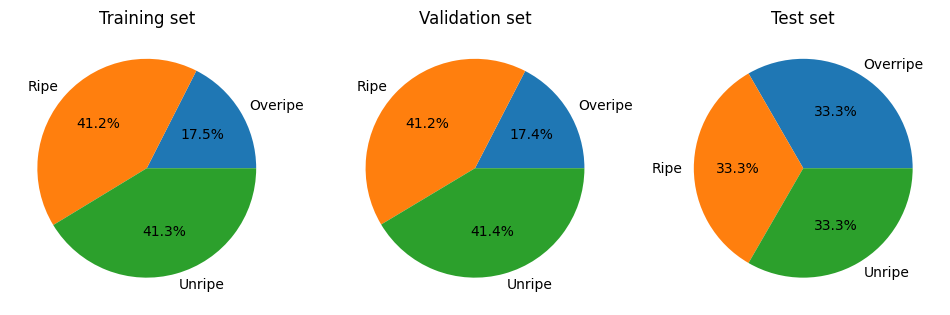

In [10]:
visualizer.show_data_distribution(train_gen, val_gen, test_gen)

## 5. Building Models

### 5.1 Inception V3 Pretrained Model

In [11]:
inception_model = PretrainedModel(image_size=conf.image_size,
                                  num_classes=conf.num_classes,
                                  base_model=InceptionV3,
                                  name='Pretrained_InceptionV3'
                                 )
inception_model.compile(optimizer=conf.optimizer(learning_rate=conf.learning_rate),
                        loss=conf.loss,
                        metrics=conf.metrics
                       )
inception_model.summary()

I0000 00:00:1747295134.903492      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Pretrained_InceptionV3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,360,611 (85.30 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### 5.2 VGG 19 Pretrained Model

In [12]:
vgg_model = PretrainedModel(image_size=conf.image_size,
                            num_classes=conf.num_classes,
                            base_model=VGG19,
                            name='Pretrained_VGG19'
                           )
vgg_model.compile(optimizer=conf.optimizer(learning_rate=conf.learning_rate),
                  loss=conf.loss,
                  metrics=conf.metrics
                 )
vgg_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Pretrained_VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,188,995 (77.01 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

### 5.3 Xception Pretrained Model

In [13]:
xception_model = PretrainedModel(image_size=conf.image_size,
                            num_classes=conf.num_classes,
                            base_model=Xception,
                            name='Pretrained_Xception'
                           )
xception_model.compile(optimizer=conf.optimizer(learning_rate=conf.learning_rate),
                  loss=conf.loss,
                  metrics=conf.metrics
                 )
xception_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Pretrained_Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,419,307 (81.71 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 6. Training

### 6.1 Inception V3 Pretrained

In [14]:
inception_history = inception_model.fit(train_gen,
                                        validation_data=val_gen,
                                        epochs=conf.epochs,
                                        verbose=1
                                       )

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747295166.028477     113 service.cc:148] XLA service 0x7df55805bac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747295166.029306     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747295168.043420     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/63 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.5769 - categorical_accuracy: 0.3984 - loss: 1.4518 - precision: 0.3642 - recall: 0.2461  

I0000 00:00:1747295175.981207     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - auc: 0.7859 - categorical_accuracy: 0.6012 - loss: 0.9026 - precision: 0.6350 - recall: 0.5178 - val_auc: 0.8752 - val_categorical_accuracy: 0.6900 - val_loss: 0.6624 - val_precision: 0.7346 - val_recall: 0.6199
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 849ms/step - auc: 0.9383 - categorical_accuracy: 0.8116 - loss: 0.4700 - precision: 0.8271 - recall: 0.7956 - val_auc: 0.8795 - val_categorical_accuracy: 0.7285 - val_loss: 0.6589 - val_precision: 0.7343 - val_recall: 0.7127
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 851ms/step - auc: 0.9464 - categorical_accuracy: 0.8193 - loss: 0.4388 - precision: 0.8345 - recall: 0.8068 - val_auc: 0.8836 - val_categorical_accuracy: 0.7262 - val_loss: 0.6511 - val_precision: 0.7421 - val_recall: 0.6900
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 839ms/step - auc: 0.9576 - categorical_accuracy: 0.8447 - loss: 0.3896 - precision: 0.8539 - recall: 0.8390 - val_auc: 0.8736 - val_categorical_accuracy: 0.7036 - val_los

### 6.2 VGG 19 Pretrained

In [15]:
train_gen.reset()
val_gen.reset()

In [16]:
vgg_history = vgg_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=conf.epochs,
                            verbose=1
                           )

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - auc: 0.6534 - categorical_accuracy: 0.4561 - loss: 1.0331 - precision: 0.4948 - recall: 0.1972 - val_auc: 0.7349 - val_categorical_accuracy: 0.4842 - val_loss: 0.9063 - val_precision: 0.5299 - val_recall: 0.3009
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 870ms/step - auc: 0.8191 - categorical_accuracy: 0.6307 - loss: 0.8027 - precision: 0.7050 - recall: 0.5015 - val_auc: 0.7609 - val_categorical_accuracy: 0.5566 - val_loss: 0.8799 - val_precision: 0.5752 - val_recall: 0.3982
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 856ms/step - auc: 0.8689 - categorical_accuracy: 0.6931 - loss: 0.6869 - precision: 0.7368 - recall: 0.6082 - val_auc: 0.8103 - val_categorical_accuracy: 0.6018 - val_loss: 0.7995 - val_precision: 0.6438 - val_recall: 0.5317
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 858ms/step - auc: 0.8881 - categorical_accuracy: 0.7220 - loss: 0.6394 - precision: 0.7602 - recall: 0.6641 - val_auc: 0.7699 - val_categorical_accuracy: 0.5747

### 6.3 Xception Pretrained

In [17]:
train_gen.reset()
val_gen.reset()

In [18]:
xception_history = xception_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=conf.epochs,
                            verbose=1
                           )

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.8691 - categorical_accuracy: 0.7055 - loss: 0.6712 - precision: 0.7568 - recall: 0.6330 - val_auc: 0.9081 - val_categorical_accuracy: 0.7489 - val_loss: 0.5863 - val_precision: 0.7571 - val_recall: 0.7262
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 858ms/step - auc: 0.9659 - categorical_accuracy: 0.8668 - loss: 0.3491 - precision: 0.8742 - recall: 0.8573 - val_auc: 0.8998 - val_categorical_accuracy: 0.7376 - val_loss: 0.6220 - val_precision: 0.7506 - val_recall: 0.7149
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 855ms/step - auc: 0.9674 - categorical_accuracy: 0.8683 - loss: 0.3406 - precision: 0.8783 - recall: 0.8615 - val_auc: 0.9070 - val_categorical_accuracy: 0.7534 - val_loss: 0.5981 - val_precision: 0.7616 - val_recall: 0.7443
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 857ms/step - auc: 0.9825 - categorical_accuracy: 0.9132 - loss: 0.2461 - precision: 0.9164 - recall: 0.9070 - val_auc: 0.9049 - val_categorical_accuracy: 0.7670

## 7. Evaluation on Test Data

### 7.1 Inception V3 Pretrained

In [19]:
y_pred_inception = inception_model.predict(test_gen)

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step


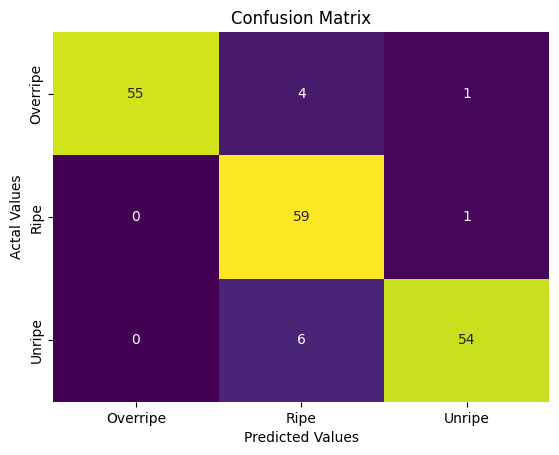

In [20]:
visualizer.show_confusion_matrix(test_gen.labels, y_pred_inception.argmax(axis=1), labels=test_gen.class_indices.keys())

In [21]:
visualizer.show_classification_report(test_gen.labels, y_pred_inception.argmax(axis=1), test_gen.class_indices.keys())

Classification Report

              precision    recall  f1-score   support

    Overripe       1.00      0.92      0.96        60
        Ripe       0.86      0.98      0.91        60
      Unripe       0.96      0.90      0.93        60

    accuracy                           0.93       180
   macro avg       0.94      0.93      0.93       180
weighted avg       0.94      0.93      0.93       180



### 7.2 VGG 19 Pretrained

In [22]:
y_pred_vgg = vgg_model.predict(test_gen)

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step 


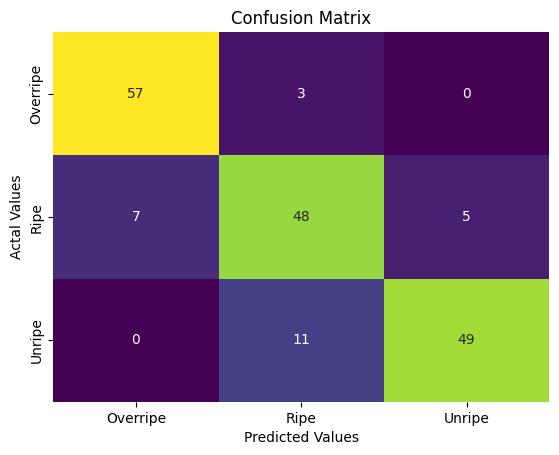

In [23]:
visualizer.show_confusion_matrix(test_gen.labels, y_pred_vgg.argmax(axis=1), labels=test_gen.class_indices.keys())

In [24]:
visualizer.show_classification_report(test_gen.labels, y_pred_vgg.argmax(axis=1), test_gen.class_indices.keys())

Classification Report

              precision    recall  f1-score   support

    Overripe       0.89      0.95      0.92        60
        Ripe       0.77      0.80      0.79        60
      Unripe       0.91      0.82      0.86        60

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



### 7.3 Xception Pretrained

In [25]:
y_pred_xception = xception_model.predict(test_gen)

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step 


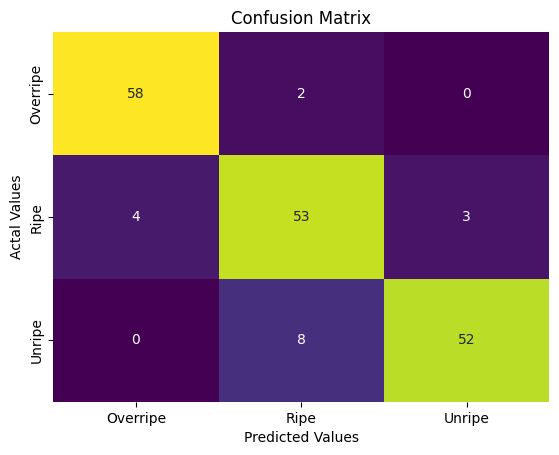

In [26]:
visualizer.show_confusion_matrix(test_gen.labels, y_pred_xception.argmax(axis=1), labels=test_gen.class_indices.keys())

In [27]:
visualizer.show_classification_report(test_gen.labels, y_pred_xception.argmax(axis=1), test_gen.class_indices.keys())

Classification Report

              precision    recall  f1-score   support

    Overripe       0.94      0.97      0.95        60
        Ripe       0.84      0.88      0.86        60
      Unripe       0.95      0.87      0.90        60

    accuracy                           0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180



## 8. Save Model

In [30]:
inception_model.save(f'/kaggle/working/inception_224_0.001_64_30.keras')
vgg_model.save(f'/kaggle/working/vgg_224_0.001_64_30.keras')
xception_model.save(f'/kaggle/working/xception_224_0.001_64_30.keras')